<a href="https://colab.research.google.com/github/favrng/quadcopter-thesis/blob/Master/Quadcopter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install control

In [ ]:
#Import library
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from numpy import random #for noise

In [ ]:
#Defining Constants
m = 1.776 #quadcopter mass
g = 9.8 #gravity
b = 0.0087 #lift constant
k = 0.0055e-2 #drag constant
d = 0.225 #rotor axis to center of mass distance

Parameter taken from [DJI F450 drone](https://www.researchgate.net/figure/DJI-F450-quadcopter-parameters-and-observer-design-values_tbl1_344008865)


In [ ]:
#Inertia matrix (J)
Ixx = 0.0035
Iyy = 0.0035
Izz = 0.0055

Ixy = Iyx = 0
Ixz = Izx = 0
Iyz = Izy = 0

J = np.array([
    [Ixx, Ixy, Ixz],
    [Iyx, Iyy, Iyz],
    [Izx, Izy, Izz]
])

print(J)

[[0.0035 0.     0.    ]
 [0.     0.0035 0.    ]
 [0.     0.     0.0055]]


In [ ]:
#Parameter
B = 0.5 # aerodynamic friction

#Rotor speed
# w_bar_0 = 101
# w_bar_1 = 100
# w_bar_2 = 99
# w_bar_3 = 100

# w_bar_0_sq = w_bar_0**2
# w_bar_1_sq = w_bar_1**2
# w_bar_2_sq = w_bar_2**2
# w_bar_3_sq = w_bar_3**2
# w_bar_sq = [w_bar_0_sq, w_bar_1_sq, w_bar_2_sq, w_bar_3_sq]

#Thrust as input
# Ti = [b*(wi) for wi in w_bar_sq]
# print(Ti)
# print(sum(Ti))

#Initial Conditions: Position
x = 0
y = 0
z = -1
vx = 0
vy = 0
vz = 0

#Initial Conditions: Orientation
roll = 0.1
pitch = 0.1
yaw =  0
#benarkah harus ada initial condition for rpy dot?
roll_dot = 0
pitch_dot = 0
yaw_dot = 0
wx = 0
wy = 0
wz = 0

**State Feedback**

State Equation $\dot{x} = Ax + Bu$



Output Equation $y = Cx + Du$


In [ ]:
def f_linear (A, B, x, u):
  x_dot = A@x + B@u
  return x_dot

def g_linear (C, D, x, u):
  y = C@x + D@u
  return y

In [ ]:
A_mat = np.array([[0, 1],
    [0, (-B/m)]])
B_mat = np.array ([[0], [1]])
C_mat = np.array ([[1, 0]]) #asumsikan output adalah posisi z
D_mat = np.array ([[0]])

In [ ]:
u = np.empty(0)
print ("A matrix:, ", A_mat)
print ("B matrix:, ", B_mat)
print ("C matrix: ", C_mat)
print ("D matrix: ", D_mat)
print ("Input: ", u)

E = ct.ctrb(A_mat, B_mat)
print("Controllability matrix rank: ", np.linalg.matrix_rank(E))
print(E)

A matrix:,  [[ 0.          1.        ]
 [ 0.         -0.28153153]]
B matrix:,  [[0]
 [1]]
C matrix:  [[1 0]]
D matrix:  [[0]]
Input:  []
Controllability matrix rank:  2
[[ 0.          1.        ]
 [ 1.         -0.28153153]]


In [ ]:
desired_poles = np.array([[complex(-1, 1), complex(-1, -1)]])
# print(np.shape(desired_poles))
K = ct.place(A_mat, B_mat, desired_poles)
print("Gain: ", K)

Gain:  [[2.         1.71846847]]


In [ ]:
A_mat_new = A_mat - np.dot(B_mat, K)
s = ct.pole(ct.ss(A_mat_new, B_mat, C_mat, D_mat))
print ("Poles for verification: ", s)

Poles for verification:  [-1.+1.j -1.-1.j]


In [ ]:
ss_matrix = np.block ([[A_mat, B_mat], [C_mat, D_mat]])
print (ss_matrix)

[[ 0.          1.          0.        ]
 [ 0.         -0.28153153  1.        ]
 [ 1.          0.          0.        ]]


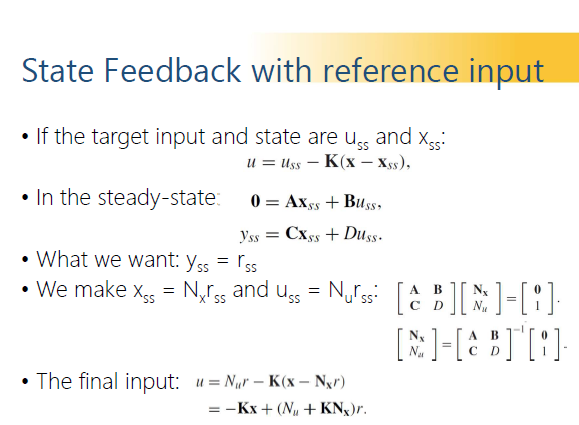

In [ ]:
steady_state_vector = np.block([[np.zeros((2, 1))], [1]])
print (steady_state_vector)

[[0.]
 [0.]
 [1.]]


In [ ]:
N = np.linalg.solve(ss_matrix, steady_state_vector)
Nx = N[:2, :]
Nu = N[2:, :]
print("N= ", N)
print("Nx = ", Nx)
print("Nu = ", Nu)

N=  [[1.]
 [0.]
 [0.]]
Nx =  [[1.]
 [0.]]
Nu =  [[0.]]


Function Definition (for dynamics)

In [ ]:
#Roll pitch yaw to rotation matrix conversion
def rpy_to_rot (roll, pitch, yaw):
  rot_z = np.array([
      [np.cos(yaw), -np.sin(yaw), 0],
      [np.sin(yaw), np.cos(yaw), 0],
      [0, 0, 1]])
  rot_y = np.array([
      [np.cos(pitch), 0, np.sin(pitch)],
      [0, 1, 0],
      [-np.sin(pitch), 0, np.cos(pitch)]])
  rot_x = np.array([
      [1, 0, 0],
      [0, np.cos(roll), -np.sin(roll)],
      [0, np.sin(roll), np.cos(roll)]])
  R = rot_z @ rot_y @ rot_x
  # print ("Rotation matrix:\n", R)
  return R

In [ ]:
def w_to_ypr_dot (w, roll, pitch, yaw):
  E = np.array([
      [-np.sin(pitch), 0, 1],
      [np.cos(pitch)*np.sin(roll), np.cos(roll), 0],
      [np.cos(pitch)*np.cos(roll), -np.sin(pitch), 0]
  ])
  ypr_dot = E @ w
  return ypr_dot

In [ ]:
#PD controller function
def pd_controller(desired_angle, current_angle, desired_rate, current_rate, Kp, Kd):
    error = desired_angle - current_angle
    error_rate = desired_rate - current_rate
    torque = Kp*error + Kd*error_rate
    return torque

In [ ]:
def get_w_bar_sq (thrust_torque_vector):
  P = np.array([
        [-b, -b, -b, -b],
        [0, -d*b, 0, d*b],
        [d*b, 0, -d*b, 0],
        [k, -k, k, -k]
    ]) #Control allocation matrix
  P_inv = np.linalg.inv(P)
  w_bar_sq_vector = P_inv @ thrust_torque_vector
  return w_bar_sq_vector

Loop

In [ ]:
#Desired state feedback output (z position)
r = -1.5 #reference tracking

In [ ]:
#Desired PD controller output
desired_roll = 0
desired_pitch = 0
desired_yaw = 0

desired_roll_dot = 0
desired_pitch_dot = 0
desired_yaw_dot = 0

In [ ]:
#PD controller gain parameters
Kp = 0.2
Kd = 0.5

In [ ]:
#Lists initialization (for storing history of values)
pos_values, v_values, w_values, rpy_values, rpy_dot_values = ([] for _ in range(5))
u_values = []
tau_values = []

#Initial conditions
pos = np.array([[x], [y], [z]])
v = np.array([[vx], [vy], [vz]])
w = np.array([[wx], [wy], [wz]])
rpy = np.array([[roll], [pitch], [yaw]])
rpy_dot = np.array([[roll_dot], [pitch_dot], [yaw_dot]])

#Storing initial conditions
pos_values.append(pos.flatten())
v_values.append(v.flatten())
w_values.append(w.flatten())
rpy_values.append(rpy.flatten())
rpy_dot_values.append(rpy_dot.flatten())

J_inv = np.linalg.inv(J)
delta_t = 0.0001
num_steps = 100000

for i in range (num_steps):
  #Step 1: Hitung thrust masing-masing rotor
  # Ti = [b*(wi**2) for wi in w_bar] = u
  x_sf = np.array([[z], [vz]]) #Initial condition, z dan vz
  u = -(K @ x_sf) + (Nu + (K @ Nx))*r
  u = (g - u)*m
  # print ("u = ", u[0][0])

  #Step 2: Hitung torque roll, pitch, yaw axis
  # when T0 = T1 = T2 = T3 = 1/4*T,
  # since u = T = b*w_bar_sq, therefore:
  # w_bar_sq = u[0][0]/b #total w bar sq
  # w_bar_0_sq = w_bar_1_sq = w_bar_2_sq = w_bar_3_sq = (1/4)*w_bar_sq
  # tau_x = d*b*((w_bar_3_sq)-(w_bar_1_sq)) + random.uniform(-0.005, 0.005)
  # tau_y = d*b*((w_bar_0_sq)-(w_bar_2_sq)) #+ random.uniform(-0.005, 0.005)
  # tau_z = k*(w_bar_0_sq - w_bar_1_sq + w_bar_2_sq - w_bar_3_sq) #+ random.uniform(-0.005, 0.005)

  #case: tau pake Kp Kd
  T = u[0][0] #state feedback
  tau_x = pd_controller(desired_roll, roll, desired_roll_dot, roll_dot, Kp, Kd)
  tau_y = pd_controller(desired_pitch, pitch, desired_pitch_dot, pitch_dot, Kp, Kd)
  tau_z = pd_controller(desired_yaw, yaw, desired_yaw_dot, yaw_dot, Kp, Kd)
  tau = np.array([[tau_x], [tau_y], [tau_z]])
  thrust_torque_vector = np.vstack(([T], tau))
  #cari w_bar_sq masing2 rotor dari invers matriks
  #trus buat apa ya? hanya untuk tau input signalnya saja?
  w_bar_sq_vector = get_w_bar_sq(thrust_torque_vector)

  #Step 3: Dinamika rotasi -> hitung omega dot
  w_cross_Jw = np.cross((-w).flatten(), (J@w).flatten()).reshape(-1,1)
  w_dot = J_inv @ (w_cross_Jw + tau)
  # print("omega:", w_dot)

  # print ("rpy:", rpy)
  # print ("roll", roll)
  # print ("pitch", pitch)
  # print ("yaw", yaw)


  #Step 4: Dinamika translasi -> hitung v dot
  gravity_vector = np.array([[0], [0], [m*g]])
  R = rpy_to_rot(roll, pitch, yaw)
  # T = sum(Ti) -> ga kepake
  # T = u[0][0] #state feedback
  thrust_body = np.array([[0], [0], [T]])
  thrust_inertial = R@thrust_body
  # print(thrust_inertial)
  drag_force = B*v
  v_dot = (1/m)*(gravity_vector - thrust_inertial - drag_force)


  #Step 5: Update v dan xyz dengan numerical integration
  v = v + v_dot*delta_t
  vz = v[2][0] #put values into vz variable for state feedback next loop
  pos = pos + v*delta_t
  z = pos[2][0]


  #Step 6: Update omega dan rpy
  w = w + w_dot*delta_t
  ypr_dot = w_to_ypr_dot (w, roll, pitch, yaw)
  # print ("ypr dot", ypr_dot)
  rpy_dot = np.array([ypr_dot[2], ypr_dot[1], ypr_dot[0]])
  roll_dot = rpy_dot[0][0]
  pitch_dot = rpy_dot[1][0]
  yaw_dot = rpy_dot[2][0]
  # print ("rpy dot:", rpy_dot)
  rpy = rpy + rpy_dot*delta_t
  roll = rpy[0][0]
  pitch = rpy[1][0]
  yaw = rpy[2][0]

  #Step 7: Appending values
  v_values.append(v.flatten())
  pos_values.append(pos.flatten())
  w_values.append(w.flatten())
  rpy_values.append(rpy.flatten())
  rpy_dot_values.append(rpy_dot.flatten())
  u_values.append(u.flatten())
  tau_values.append(tau.flatten())

v_values = np.array(v_values)
pos_values = np.array(pos_values)
w_values = np.array(w_values)
rpy_values = np.array(rpy_values)
rpy_dot_values = np.array(rpy_dot_values)
u_values = np.array(u_values)
tau_values = np.array(tau_values)

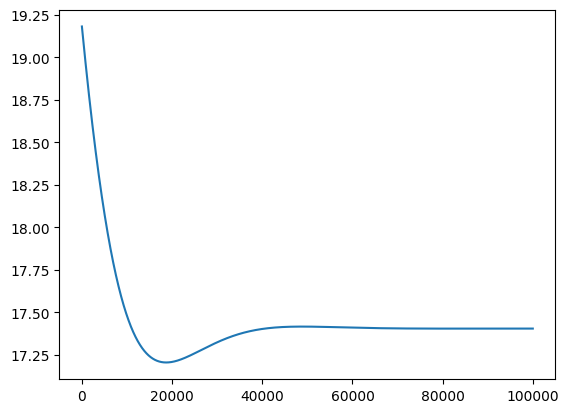

In [ ]:
plt.plot(u_values)

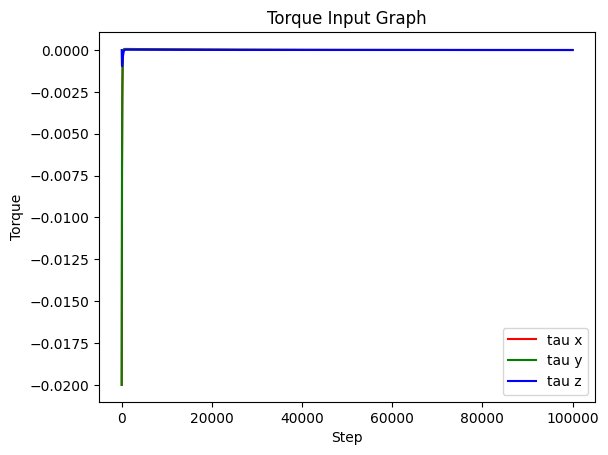

In [ ]:
plt.plot(tau_values[:, 0], color='r', label='tau x')
plt.plot(tau_values[:, 1], color='g', label='tau y')
plt.plot(tau_values[:, 2], color='b', label='tau z')
plt.title('Torque Input Graph')
plt.xlabel('Step')
plt.ylabel('Torque')
plt.legend()

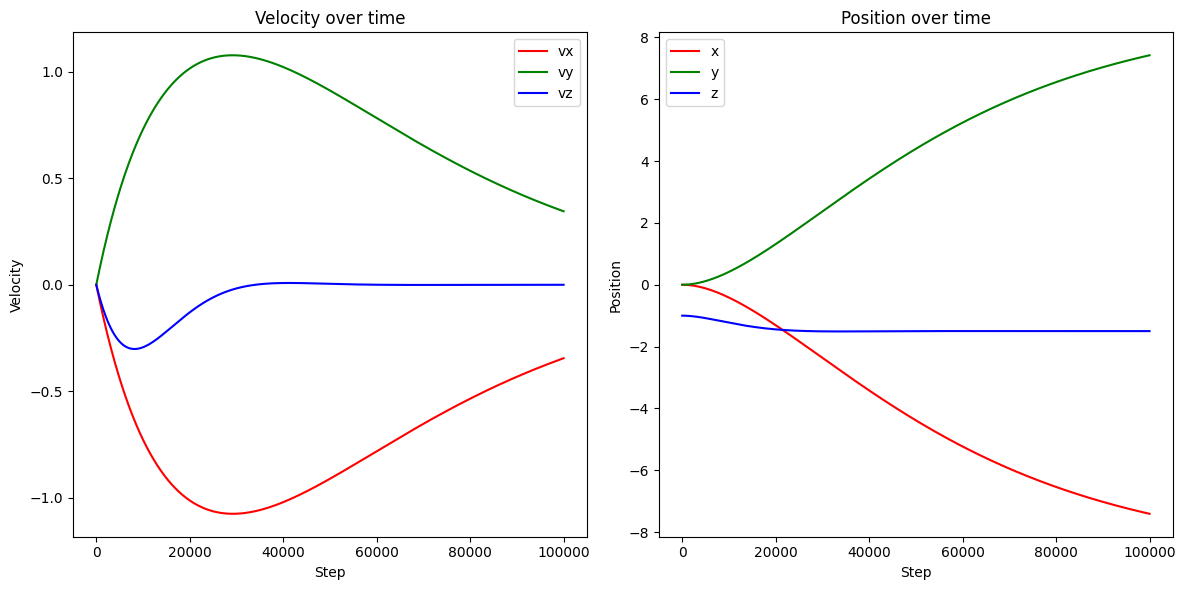

In [ ]:
# Plotting velocity and position
plt.figure(figsize=(12, 6))

# Plotting velocity
plt.subplot(1, 2, 1)
plt.plot(v_values[:, 0], color='r', label='vx')
plt.plot(v_values[:, 1], color='g', label='vy')
plt.plot(v_values[:, 2], color='b', label='vz')
plt.title('Velocity over time')
plt.xlabel('Step')
plt.ylabel('Velocity')
plt.legend()

# Plotting position
plt.subplot(1, 2, 2)
plt.plot(pos_values[:, 0], color='r', label='x')
plt.plot(pos_values[:, 1], color='g', label='y')
plt.plot(pos_values[:, 2], color='b', label='z')
plt.title('Position over time')
plt.xlabel('Step')
plt.ylabel('Position')
plt.legend()

plt.tight_layout()
plt.show()

Text(0.5, 0, 'z')

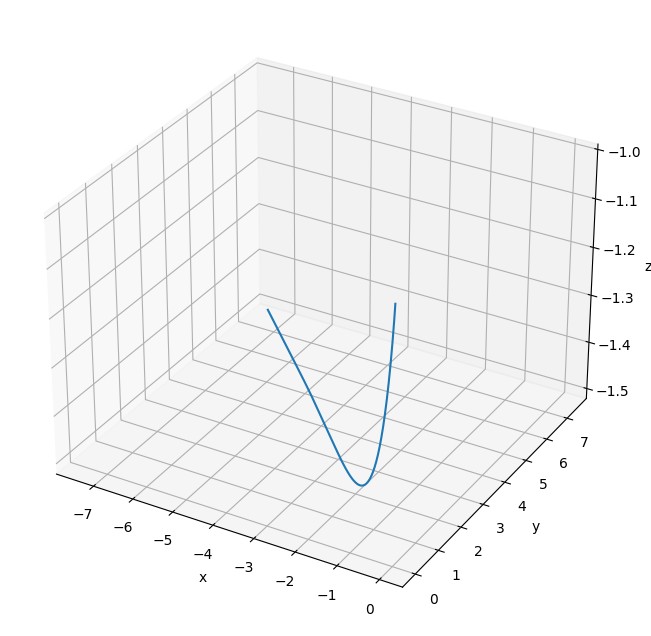

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(pos_values[:, 0], pos_values[:, 1], pos_values[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

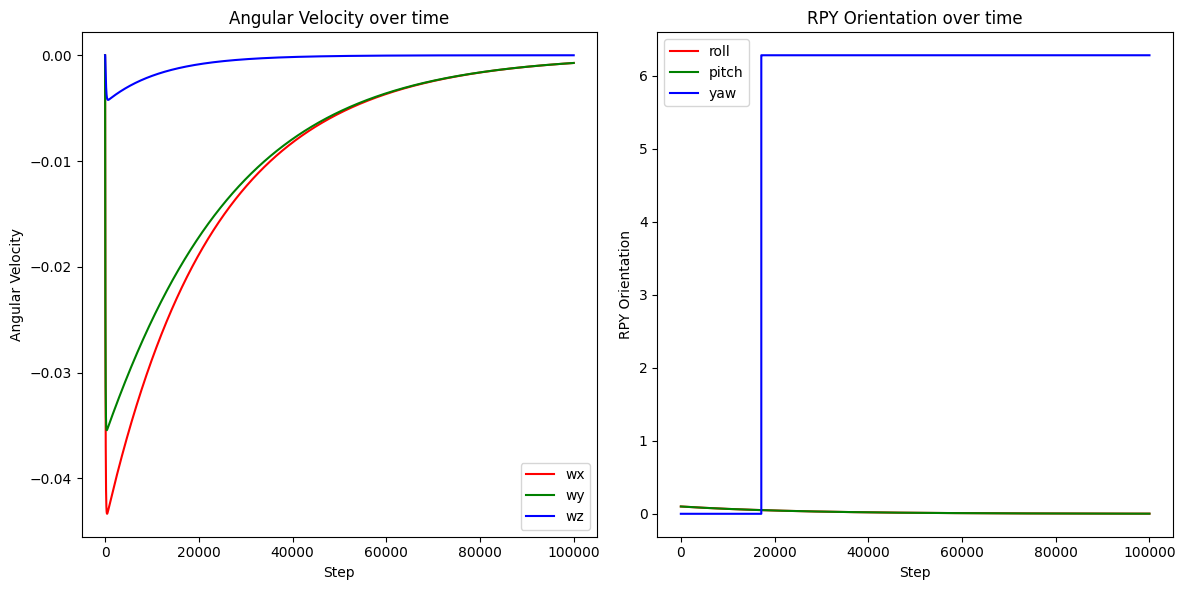

In [ ]:
plt.figure(figsize=(12, 6))
rpy_0_to_2pi = np.mod(rpy_values, 2*np.pi)


# Plotting angular velocity
plt.subplot(1, 2, 1)
plt.plot(w_values[:, 0], color='r', label='wx')
plt.plot(w_values[:, 1], color='g', label='wy')
plt.plot(w_values[:, 2], color='b', label='wz')
plt.title('Angular Velocity over time')
plt.xlabel('Step')
plt.ylabel('Angular Velocity')
plt.legend()

# Plotting rpy orientation
plt.subplot(1, 2, 2)
plt.plot(rpy_0_to_2pi[:, 0], color='r', label='roll')
plt.plot(rpy_0_to_2pi[:, 1], color='g', label='pitch')
plt.plot(rpy_0_to_2pi[:, 2], color='b', label='yaw')
plt.title('RPY Orientation over time')
plt.xlabel('Step')
plt.ylabel('RPY Orientation')
plt.legend()

plt.tight_layout()
plt.show()